# Mobile price classification with multilayer perceptron
## Tensorflow
Erik Matovič and Jakub Horvat

[Dataset](https://www.kaggle.com/datasets/iabhishekofficial/mobile-price-classification?select=train.csv)

Predict a price range indicating how high the price is

### 0. Imports

In [1]:
from utils import split_train_val
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
from sklearn.model_selection import train_test_split
from utils import check_null_values, print_sum_null, rescale, split_data

In [2]:
# api = wandb.Api()
# sweep = api.sweep("xmatovice/uncategorized/1stel95e") #2hfg3dq6") #1kmqujzs")
#
# best_config = sweep.best_run().config
# pprint(best_config)
#
# wandb.init(config=best_config, project='uncategorized', name='NSIETE_zad1_final')
# config = wandb.config

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))


2.11.0
Num GPUs Available:  0
tf.Tensor(105.4964, shape=(), dtype=float32)
[]


In [4]:
wandb.login()
run=wandb.init(project="nsiete1")

wandb: Currently logged in as: jakub-horvat56 (testsd). Use `wandb login --relogin` to force relogin


### 1. Data Preprocessing

Based on [exploratory data analysis](EDA.ipynb) test set does not have target variable price_range. We split our dataset into train-dev-test. We have train and test sets, but we split test set by half to dev-test sets. We will rougly have train-dev-test 67%-16.5%-16.5%. 

In [5]:
# read datasets
df_train = pd.read_csv('../data/train.csv', sep=',')
df_train


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0


In [6]:
df_test = pd.read_csv('../data/test.csv', sep=',', index_col=0)
#df_test

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
id,,,,,,,,,,,,,,,,,,,,
1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0
2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0
3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1
4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0
5,1434,0,1.4,0,11,1,49,0.5,108,6,18,749,810,1773,15,8,7,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1700,1,1.9,0,0,1,54,0.5,170,7,17,644,913,2121,14,8,15,1,1,0
997,609,0,1.8,1,0,0,13,0.9,186,4,2,1152,1632,1933,8,1,19,0,1,1
998,1185,0,1.4,0,1,1,8,0.5,80,1,12,477,825,1223,5,0,14,1,0,0


In [7]:
df_train.values

array([[8.420e+02, 0.000e+00, 2.200e+00, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       [1.021e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        2.000e+00],
       [5.630e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        2.000e+00],
       ...,
       [1.911e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 0.000e+00,
        3.000e+00],
       [1.512e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [5.100e+02, 1.000e+00, 2.000e+00, ..., 1.000e+00, 1.000e+00,
        3.000e+00]])

In [8]:
x_train = df_train.values[:, :-1]       #vsetko okrem price range
x_train = x_train.astype('float32')     # input data as floats
#x_train

array([[8.420e+02, 0.000e+00, 2.200e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [1.021e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [5.630e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [1.911e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        0.000e+00],
       [1.512e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [5.100e+02, 1.000e+00, 2.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], dtype=float32)

In [9]:
y_train = df_train.values[:, -1]  # price range
y_train = y_train.astype('int')
print(y_train)

[1 2 2 ... 3 0 3]


In [10]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.2,random_state=52)
print(x_train.shape,x_val.shape,y_train.shape,y_val.shape)
#print(y_train," sad")
class_labels = [0, 1, 2, 3]
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(class_labels))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(class_labels))
#print(y_train)

(1600, 20) (400, 20) (1600,) (400,)


In [11]:
x_test = df_test.values[:, :]       #vsetko okrem price range
x_test = x_test.astype('float32')
x_test

array([[1.043e+03, 1.000e+00, 1.800e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [8.410e+02, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.807e+03, 1.000e+00, 2.800e+00, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       ...,
       [1.185e+03, 0.000e+00, 1.400e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.533e+03, 1.000e+00, 5.000e-01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.270e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        1.000e+00]], dtype=float32)

In [12]:
model = keras.Sequential([
    keras.layers.Dense(256,input_shape=(20,),name='l1'),
    # keras.layers.Dense(256, activation='relu',name='l2'),
    # keras.layers.Dense(256, activation='relu',name='l3'),
    # keras.layers.Dense(256, activation='sigmoid',name='l4'),
    # keras.layers.Dense(256, activation='sigmoid',name='l5'),
    keras.layers.Dense(4,activation='sigmoid',name='l6')
])


In [14]:
lr = 0.03648030109469176
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy','mse','categorical_accuracy']
              )


In [15]:
tf.debugging.enable_traceback_filtering()
history = model.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_val,y_val),
                    callbacks=[
                      WandbMetricsLogger(log_freq=5),
                      WandbModelCheckpoint("models")
                    ])

Epoch 1/100
 1/13 [=>............................] - ETA: 12s - loss: 66.8150 - accuracy: 0.3281 - mse: 0.4896 - categorical_accuracy: 0.3281

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 2s 106ms/step - loss: 329.5345 - accuracy: 0.3619 - mse: 0.3180 - categorical_accuracy: 0.3619 - val_loss: 138.8331 - val_accuracy: 0.4000 - val_mse: 0.2613 - val_categorical_accuracy: 0.4000
Epoch 2/100
 1/13 [=>............................] - ETA: 0s - loss: 154.6903 - accuracy: 0.3516 - mse: 0.2676 - categorical_accuracy: 0.3516

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 67ms/step - loss: 99.4989 - accuracy: 0.3688 - mse: 0.2801 - categorical_accuracy: 0.3688 - val_loss: 40.8215 - val_accuracy: 0.5250 - val_mse: 0.2311 - val_categorical_accuracy: 0.5250
Epoch 3/100
 1/13 [=>............................] - ETA: 0s - loss: 39.9143 - accuracy: 0.5938 - mse: 0.2192 - categorical_accuracy: 0.5938

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 36.9309 - accuracy: 0.4731 - mse: 0.2753 - categorical_accuracy: 0.4731 - val_loss: 23.8925 - val_accuracy: 0.5650 - val_mse: 0.2232 - val_categorical_accuracy: 0.5650
Epoch 4/100
 1/13 [=>............................] - ETA: 0s - loss: 25.9375 - accuracy: 0.5547 - mse: 0.2176 - categorical_accuracy: 0.5547

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 66ms/step - loss: 18.6276 - accuracy: 0.4969 - mse: 0.2533 - categorical_accuracy: 0.4969 - val_loss: 12.9460 - val_accuracy: 0.4775 - val_mse: 0.2788 - val_categorical_accuracy: 0.4775
Epoch 5/100
 1/13 [=>............................] - ETA: 0s - loss: 12.4047 - accuracy: 0.4844 - mse: 0.2514 - categorical_accuracy: 0.4844

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 9.2180 - accuracy: 0.5350 - mse: 0.2459 - categorical_accuracy: 0.5350 - val_loss: 6.0035 - val_accuracy: 0.5850 - val_mse: 0.2097 - val_categorical_accuracy: 0.5850
Epoch 6/100
 1/13 [=>............................] - ETA: 0s - loss: 5.1346 - accuracy: 0.6562 - mse: 0.1986 - categorical_accuracy: 0.6562

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 7.3244 - accuracy: 0.5525 - mse: 0.2378 - categorical_accuracy: 0.5525 - val_loss: 10.7203 - val_accuracy: 0.5150 - val_mse: 0.2855 - val_categorical_accuracy: 0.5150
Epoch 7/100
 1/13 [=>............................] - ETA: 0s - loss: 10.9705 - accuracy: 0.4766 - mse: 0.2945 - categorical_accuracy: 0.4766

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 68ms/step - loss: 5.4909 - accuracy: 0.5581 - mse: 0.2328 - categorical_accuracy: 0.5581 - val_loss: 4.7812 - val_accuracy: 0.5900 - val_mse: 0.2448 - val_categorical_accuracy: 0.5900
Epoch 8/100
 1/13 [=>............................] - ETA: 0s - loss: 3.9242 - accuracy: 0.6406 - mse: 0.2345 - categorical_accuracy: 0.6406

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 77ms/step - loss: 4.0901 - accuracy: 0.5763 - mse: 0.2321 - categorical_accuracy: 0.5763 - val_loss: 5.5451 - val_accuracy: 0.4300 - val_mse: 0.3817 - val_categorical_accuracy: 0.4300
Epoch 9/100
 1/13 [=>............................] - ETA: 0s - loss: 4.8274 - accuracy: 0.4453 - mse: 0.3436 - categorical_accuracy: 0.4453

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 97ms/step - loss: 5.4463 - accuracy: 0.5256 - mse: 0.2534 - categorical_accuracy: 0.5256 - val_loss: 4.3011 - val_accuracy: 0.5600 - val_mse: 0.3235 - val_categorical_accuracy: 0.5600
Epoch 10/100
 1/13 [=>............................] - ETA: 0s - loss: 4.4989 - accuracy: 0.5312 - mse: 0.3295 - categorical_accuracy: 0.5312

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 3.0212 - accuracy: 0.5850 - mse: 0.2303 - categorical_accuracy: 0.5850 - val_loss: 2.5850 - val_accuracy: 0.5925 - val_mse: 0.2118 - val_categorical_accuracy: 0.5925
Epoch 11/100
 1/13 [=>............................] - ETA: 0s - loss: 2.5399 - accuracy: 0.5547 - mse: 0.2171 - categorical_accuracy: 0.5547

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 90ms/step - loss: 2.6863 - accuracy: 0.5881 - mse: 0.2225 - categorical_accuracy: 0.5881 - val_loss: 2.4367 - val_accuracy: 0.5875 - val_mse: 0.2421 - val_categorical_accuracy: 0.5875
Epoch 12/100
 1/13 [=>............................] - ETA: 0s - loss: 2.6578 - accuracy: 0.5391 - mse: 0.2638 - categorical_accuracy: 0.5391

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 83ms/step - loss: 3.0123 - accuracy: 0.5625 - mse: 0.2288 - categorical_accuracy: 0.5625 - val_loss: 4.1418 - val_accuracy: 0.4675 - val_mse: 0.2141 - val_categorical_accuracy: 0.4675
Epoch 13/100
 1/13 [=>............................] - ETA: 0s - loss: 3.2153 - accuracy: 0.4922 - mse: 0.2202 - categorical_accuracy: 0.4922

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 92ms/step - loss: 2.6704 - accuracy: 0.5475 - mse: 0.2316 - categorical_accuracy: 0.5475 - val_loss: 2.1484 - val_accuracy: 0.6275 - val_mse: 0.2021 - val_categorical_accuracy: 0.6275
Epoch 14/100
 1/13 [=>............................] - ETA: 0s - loss: 2.4673 - accuracy: 0.5703 - mse: 0.2317 - categorical_accuracy: 0.5703

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 80ms/step - loss: 1.9242 - accuracy: 0.5738 - mse: 0.2221 - categorical_accuracy: 0.5738 - val_loss: 1.7250 - val_accuracy: 0.5375 - val_mse: 0.2051 - val_categorical_accuracy: 0.5375
Epoch 15/100
 1/13 [=>............................] - ETA: 0s - loss: 1.7354 - accuracy: 0.5156 - mse: 0.2304 - categorical_accuracy: 0.5156

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 72ms/step - loss: 1.4794 - accuracy: 0.5775 - mse: 0.2112 - categorical_accuracy: 0.5775 - val_loss: 1.3249 - val_accuracy: 0.6000 - val_mse: 0.1737 - val_categorical_accuracy: 0.6000
Epoch 16/100
 1/13 [=>............................] - ETA: 0s - loss: 1.3687 - accuracy: 0.5234 - mse: 0.1808 - categorical_accuracy: 0.5234

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 73ms/step - loss: 1.1883 - accuracy: 0.5944 - mse: 0.1963 - categorical_accuracy: 0.5944 - val_loss: 1.1926 - val_accuracy: 0.6675 - val_mse: 0.1821 - val_categorical_accuracy: 0.6675
Epoch 17/100
 1/13 [=>............................] - ETA: 0s - loss: 1.2168 - accuracy: 0.6172 - mse: 0.1898 - categorical_accuracy: 0.6172

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 67ms/step - loss: 1.0341 - accuracy: 0.6006 - mse: 0.1890 - categorical_accuracy: 0.6006 - val_loss: 0.8548 - val_accuracy: 0.6450 - val_mse: 0.1677 - val_categorical_accuracy: 0.6450
Epoch 18/100
 1/13 [=>............................] - ETA: 0s - loss: 0.8690 - accuracy: 0.6328 - mse: 0.1882 - categorical_accuracy: 0.6328

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 73ms/step - loss: 1.1247 - accuracy: 0.5706 - mse: 0.1835 - categorical_accuracy: 0.5706 - val_loss: 1.2176 - val_accuracy: 0.6050 - val_mse: 0.1979 - val_categorical_accuracy: 0.6050
Epoch 19/100
 1/13 [=>............................] - ETA: 0s - loss: 0.7888 - accuracy: 0.7188 - mse: 0.1718 - categorical_accuracy: 0.7188

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 87ms/step - loss: 0.9209 - accuracy: 0.5987 - mse: 0.1711 - categorical_accuracy: 0.5987 - val_loss: 0.9738 - val_accuracy: 0.5400 - val_mse: 0.1608 - val_categorical_accuracy: 0.5400
Epoch 20/100
 1/13 [=>............................] - ETA: 0s - loss: 1.2910 - accuracy: 0.3750 - mse: 0.2008 - categorical_accuracy: 0.3750

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 84ms/step - loss: 0.8028 - accuracy: 0.6031 - mse: 0.1607 - categorical_accuracy: 0.6031 - val_loss: 0.7759 - val_accuracy: 0.6500 - val_mse: 0.1545 - val_categorical_accuracy: 0.6500
Epoch 21/100
 1/13 [=>............................] - ETA: 0s - loss: 0.7430 - accuracy: 0.6406 - mse: 0.1612 - categorical_accuracy: 0.6406

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 107ms/step - loss: 0.8056 - accuracy: 0.5913 - mse: 0.1723 - categorical_accuracy: 0.5913 - val_loss: 2.9107 - val_accuracy: 0.4200 - val_mse: 0.2412 - val_categorical_accuracy: 0.4200
Epoch 22/100
 1/13 [=>............................] - ETA: 0s - loss: 2.5426 - accuracy: 0.4297 - mse: 0.2324 - categorical_accuracy: 0.4297

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 73ms/step - loss: 1.3183 - accuracy: 0.5562 - mse: 0.1870 - categorical_accuracy: 0.5562 - val_loss: 1.0475 - val_accuracy: 0.6050 - val_mse: 0.1646 - val_categorical_accuracy: 0.6050
Epoch 23/100
 1/13 [=>............................] - ETA: 0s - loss: 1.1350 - accuracy: 0.6328 - mse: 0.1611 - categorical_accuracy: 0.6328

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 0.8769 - accuracy: 0.6094 - mse: 0.1660 - categorical_accuracy: 0.6094 - val_loss: 0.9016 - val_accuracy: 0.6450 - val_mse: 0.1724 - val_categorical_accuracy: 0.6450
Epoch 24/100
 1/13 [=>............................] - ETA: 0s - loss: 0.9306 - accuracy: 0.5234 - mse: 0.1897 - categorical_accuracy: 0.5234

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 72ms/step - loss: 0.7607 - accuracy: 0.6012 - mse: 0.1683 - categorical_accuracy: 0.6012 - val_loss: 0.6955 - val_accuracy: 0.6250 - val_mse: 0.1631 - val_categorical_accuracy: 0.6250
Epoch 25/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6174 - accuracy: 0.6641 - mse: 0.1467 - categorical_accuracy: 0.6641

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 71ms/step - loss: 0.5645 - accuracy: 0.6394 - mse: 0.1457 - categorical_accuracy: 0.6394 - val_loss: 0.6439 - val_accuracy: 0.5800 - val_mse: 0.1828 - val_categorical_accuracy: 0.5800
Epoch 26/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5588 - accuracy: 0.5938 - mse: 0.1681 - categorical_accuracy: 0.5938

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 72ms/step - loss: 0.5202 - accuracy: 0.6363 - mse: 0.1535 - categorical_accuracy: 0.6363 - val_loss: 0.5691 - val_accuracy: 0.6575 - val_mse: 0.1621 - val_categorical_accuracy: 0.6575
Epoch 27/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6371 - accuracy: 0.5625 - mse: 0.1804 - categorical_accuracy: 0.5625

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 77ms/step - loss: 0.5737 - accuracy: 0.6012 - mse: 0.1659 - categorical_accuracy: 0.6012 - val_loss: 0.5942 - val_accuracy: 0.5950 - val_mse: 0.1610 - val_categorical_accuracy: 0.5950
Epoch 28/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6441 - accuracy: 0.5078 - mse: 0.1782 - categorical_accuracy: 0.5078

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 88ms/step - loss: 0.5543 - accuracy: 0.5900 - mse: 0.1612 - categorical_accuracy: 0.5900 - val_loss: 0.5270 - val_accuracy: 0.6175 - val_mse: 0.1510 - val_categorical_accuracy: 0.6175
Epoch 29/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5492 - accuracy: 0.6172 - mse: 0.1527 - categorical_accuracy: 0.6172

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 79ms/step - loss: 0.5486 - accuracy: 0.6313 - mse: 0.1623 - categorical_accuracy: 0.6313 - val_loss: 0.5345 - val_accuracy: 0.6800 - val_mse: 0.1509 - val_categorical_accuracy: 0.6800
Epoch 30/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5229 - accuracy: 0.6328 - mse: 0.1511 - categorical_accuracy: 0.6328

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.4957 - accuracy: 0.6288 - mse: 0.1522 - categorical_accuracy: 0.6288 - val_loss: 0.5499 - val_accuracy: 0.6250 - val_mse: 0.1582 - val_categorical_accuracy: 0.6250
Epoch 31/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4533 - accuracy: 0.6484 - mse: 0.1476 - categorical_accuracy: 0.6484

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 88ms/step - loss: 0.5144 - accuracy: 0.6294 - mse: 0.1490 - categorical_accuracy: 0.6294 - val_loss: 0.4958 - val_accuracy: 0.6225 - val_mse: 0.1453 - val_categorical_accuracy: 0.6225
Epoch 32/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5258 - accuracy: 0.5859 - mse: 0.1413 - categorical_accuracy: 0.5859

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 74ms/step - loss: 0.4744 - accuracy: 0.6419 - mse: 0.1424 - categorical_accuracy: 0.6419 - val_loss: 0.5631 - val_accuracy: 0.6375 - val_mse: 0.1513 - val_categorical_accuracy: 0.6375
Epoch 33/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5926 - accuracy: 0.5391 - mse: 0.1602 - categorical_accuracy: 0.5391

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 75ms/step - loss: 0.4980 - accuracy: 0.6244 - mse: 0.1521 - categorical_accuracy: 0.6244 - val_loss: 0.5850 - val_accuracy: 0.5800 - val_mse: 0.1655 - val_categorical_accuracy: 0.5800
Epoch 34/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5734 - accuracy: 0.5547 - mse: 0.1659 - categorical_accuracy: 0.5547

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 71ms/step - loss: 0.5016 - accuracy: 0.6056 - mse: 0.1497 - categorical_accuracy: 0.6056 - val_loss: 0.5083 - val_accuracy: 0.6425 - val_mse: 0.1569 - val_categorical_accuracy: 0.6425
Epoch 35/100
 1/13 [=>............................] - ETA: 0s - loss: 0.5091 - accuracy: 0.6016 - mse: 0.1548 - categorical_accuracy: 0.6016

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 72ms/step - loss: 0.4892 - accuracy: 0.6250 - mse: 0.1518 - categorical_accuracy: 0.6250 - val_loss: 0.6548 - val_accuracy: 0.5225 - val_mse: 0.1684 - val_categorical_accuracy: 0.5225
Epoch 36/100
 1/13 [=>............................] - ETA: 0s - loss: 0.6286 - accuracy: 0.4688 - mse: 0.1806 - categorical_accuracy: 0.4688

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 89ms/step - loss: 0.4763 - accuracy: 0.6369 - mse: 0.1455 - categorical_accuracy: 0.6369 - val_loss: 0.3936 - val_accuracy: 0.6650 - val_mse: 0.1238 - val_categorical_accuracy: 0.6650
Epoch 37/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3608 - accuracy: 0.6641 - mse: 0.1198 - categorical_accuracy: 0.6641

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 104ms/step - loss: 0.4033 - accuracy: 0.6612 - mse: 0.1318 - categorical_accuracy: 0.6612 - val_loss: 0.4008 - val_accuracy: 0.6500 - val_mse: 0.1300 - val_categorical_accuracy: 0.6500
Epoch 38/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3833 - accuracy: 0.6875 - mse: 0.1174 - categorical_accuracy: 0.6875

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 64ms/step - loss: 0.4216 - accuracy: 0.6456 - mse: 0.1383 - categorical_accuracy: 0.6456 - val_loss: 0.4144 - val_accuracy: 0.6200 - val_mse: 0.1378 - val_categorical_accuracy: 0.6200
Epoch 39/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4076 - accuracy: 0.6875 - mse: 0.1330 - categorical_accuracy: 0.6875

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.4176 - accuracy: 0.6531 - mse: 0.1365 - categorical_accuracy: 0.6531 - val_loss: 0.4080 - val_accuracy: 0.6775 - val_mse: 0.1299 - val_categorical_accuracy: 0.6775
Epoch 40/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4422 - accuracy: 0.6328 - mse: 0.1384 - categorical_accuracy: 0.6328

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 72ms/step - loss: 0.4140 - accuracy: 0.6575 - mse: 0.1348 - categorical_accuracy: 0.6575 - val_loss: 0.4455 - val_accuracy: 0.6250 - val_mse: 0.1397 - val_categorical_accuracy: 0.6250
Epoch 41/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4428 - accuracy: 0.6484 - mse: 0.1414 - categorical_accuracy: 0.6484

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 0.4177 - accuracy: 0.6550 - mse: 0.1360 - categorical_accuracy: 0.6550 - val_loss: 0.3960 - val_accuracy: 0.6525 - val_mse: 0.1290 - val_categorical_accuracy: 0.6525
Epoch 42/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4405 - accuracy: 0.6172 - mse: 0.1419 - categorical_accuracy: 0.6172

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3958 - accuracy: 0.6687 - mse: 0.1308 - categorical_accuracy: 0.6687 - val_loss: 0.3982 - val_accuracy: 0.6825 - val_mse: 0.1292 - val_categorical_accuracy: 0.6825
Epoch 43/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4271 - accuracy: 0.6797 - mse: 0.1316 - categorical_accuracy: 0.6797

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3843 - accuracy: 0.6800 - mse: 0.1272 - categorical_accuracy: 0.6800 - val_loss: 0.3818 - val_accuracy: 0.6600 - val_mse: 0.1256 - val_categorical_accuracy: 0.6600
Epoch 44/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3619 - accuracy: 0.7500 - mse: 0.1206 - categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 87ms/step - loss: 0.3857 - accuracy: 0.6775 - mse: 0.1285 - categorical_accuracy: 0.6775 - val_loss: 0.3819 - val_accuracy: 0.6725 - val_mse: 0.1247 - val_categorical_accuracy: 0.6725
Epoch 45/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4083 - accuracy: 0.6875 - mse: 0.1333 - categorical_accuracy: 0.6875

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 0.3897 - accuracy: 0.6894 - mse: 0.1288 - categorical_accuracy: 0.6894 - val_loss: 0.4020 - val_accuracy: 0.6400 - val_mse: 0.1318 - val_categorical_accuracy: 0.6400
Epoch 46/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3821 - accuracy: 0.6797 - mse: 0.1262 - categorical_accuracy: 0.6797

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 67ms/step - loss: 0.3816 - accuracy: 0.6881 - mse: 0.1268 - categorical_accuracy: 0.6881 - val_loss: 0.3790 - val_accuracy: 0.6600 - val_mse: 0.1270 - val_categorical_accuracy: 0.6600
Epoch 47/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3843 - accuracy: 0.6797 - mse: 0.1302 - categorical_accuracy: 0.6797

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 65ms/step - loss: 0.3778 - accuracy: 0.6744 - mse: 0.1254 - categorical_accuracy: 0.6744 - val_loss: 0.3687 - val_accuracy: 0.6875 - val_mse: 0.1234 - val_categorical_accuracy: 0.6875
Epoch 48/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4171 - accuracy: 0.6250 - mse: 0.1407 - categorical_accuracy: 0.6250

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 77ms/step - loss: 0.3722 - accuracy: 0.7038 - mse: 0.1240 - categorical_accuracy: 0.7038 - val_loss: 0.3611 - val_accuracy: 0.7100 - val_mse: 0.1178 - val_categorical_accuracy: 0.7100
Epoch 49/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3925 - accuracy: 0.6172 - mse: 0.1272 - categorical_accuracy: 0.6172

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 0.3893 - accuracy: 0.6694 - mse: 0.1301 - categorical_accuracy: 0.6694 - val_loss: 0.4138 - val_accuracy: 0.6600 - val_mse: 0.1347 - val_categorical_accuracy: 0.6600
Epoch 50/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4477 - accuracy: 0.6406 - mse: 0.1478 - categorical_accuracy: 0.6406

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 68ms/step - loss: 0.3948 - accuracy: 0.6606 - mse: 0.1307 - categorical_accuracy: 0.6606 - val_loss: 0.3681 - val_accuracy: 0.6950 - val_mse: 0.1211 - val_categorical_accuracy: 0.6950
Epoch 51/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3801 - accuracy: 0.6406 - mse: 0.1254 - categorical_accuracy: 0.6406

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 72ms/step - loss: 0.3750 - accuracy: 0.6969 - mse: 0.1257 - categorical_accuracy: 0.6969 - val_loss: 0.3662 - val_accuracy: 0.6650 - val_mse: 0.1183 - val_categorical_accuracy: 0.6650
Epoch 52/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3614 - accuracy: 0.7188 - mse: 0.1180 - categorical_accuracy: 0.7188

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 68ms/step - loss: 0.3714 - accuracy: 0.7081 - mse: 0.1233 - categorical_accuracy: 0.7081 - val_loss: 0.4069 - val_accuracy: 0.7450 - val_mse: 0.1361 - val_categorical_accuracy: 0.7450
Epoch 53/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3902 - accuracy: 0.7500 - mse: 0.1328 - categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 65ms/step - loss: 0.3812 - accuracy: 0.7031 - mse: 0.1263 - categorical_accuracy: 0.7031 - val_loss: 0.3620 - val_accuracy: 0.7100 - val_mse: 0.1210 - val_categorical_accuracy: 0.7100
Epoch 54/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3797 - accuracy: 0.6953 - mse: 0.1263 - categorical_accuracy: 0.6953

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 68ms/step - loss: 0.3656 - accuracy: 0.7044 - mse: 0.1224 - categorical_accuracy: 0.7044 - val_loss: 0.3830 - val_accuracy: 0.6400 - val_mse: 0.1277 - val_categorical_accuracy: 0.6400
Epoch 55/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3988 - accuracy: 0.6484 - mse: 0.1325 - categorical_accuracy: 0.6484

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3932 - accuracy: 0.6556 - mse: 0.1305 - categorical_accuracy: 0.6556 - val_loss: 0.3761 - val_accuracy: 0.6925 - val_mse: 0.1264 - val_categorical_accuracy: 0.6925
Epoch 56/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3850 - accuracy: 0.6719 - mse: 0.1301 - categorical_accuracy: 0.6719

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 66ms/step - loss: 0.3856 - accuracy: 0.6631 - mse: 0.1295 - categorical_accuracy: 0.6631 - val_loss: 0.3508 - val_accuracy: 0.7100 - val_mse: 0.1165 - val_categorical_accuracy: 0.7100
Epoch 57/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3594 - accuracy: 0.6797 - mse: 0.1201 - categorical_accuracy: 0.6797

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3578 - accuracy: 0.7125 - mse: 0.1198 - categorical_accuracy: 0.7125 - val_loss: 0.3422 - val_accuracy: 0.7275 - val_mse: 0.1123 - val_categorical_accuracy: 0.7275
Epoch 58/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3609 - accuracy: 0.6875 - mse: 0.1193 - categorical_accuracy: 0.6875

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 71ms/step - loss: 0.3780 - accuracy: 0.6781 - mse: 0.1257 - categorical_accuracy: 0.6781 - val_loss: 0.3606 - val_accuracy: 0.7350 - val_mse: 0.1216 - val_categorical_accuracy: 0.7350
Epoch 59/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3836 - accuracy: 0.6797 - mse: 0.1304 - categorical_accuracy: 0.6797

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3841 - accuracy: 0.6981 - mse: 0.1274 - categorical_accuracy: 0.6981 - val_loss: 0.3806 - val_accuracy: 0.6925 - val_mse: 0.1286 - val_categorical_accuracy: 0.6925
Epoch 60/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4042 - accuracy: 0.6719 - mse: 0.1371 - categorical_accuracy: 0.6719

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 68ms/step - loss: 0.3905 - accuracy: 0.6888 - mse: 0.1304 - categorical_accuracy: 0.6888 - val_loss: 0.3956 - val_accuracy: 0.6525 - val_mse: 0.1318 - val_categorical_accuracy: 0.6525
Epoch 61/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4337 - accuracy: 0.5859 - mse: 0.1460 - categorical_accuracy: 0.5859

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 85ms/step - loss: 0.3727 - accuracy: 0.6963 - mse: 0.1256 - categorical_accuracy: 0.6963 - val_loss: 0.3732 - val_accuracy: 0.6800 - val_mse: 0.1222 - val_categorical_accuracy: 0.6800
Epoch 62/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3920 - accuracy: 0.6484 - mse: 0.1317 - categorical_accuracy: 0.6484

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 68ms/step - loss: 0.3789 - accuracy: 0.6888 - mse: 0.1261 - categorical_accuracy: 0.6888 - val_loss: 0.3745 - val_accuracy: 0.7175 - val_mse: 0.1251 - val_categorical_accuracy: 0.7175
Epoch 63/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4199 - accuracy: 0.6406 - mse: 0.1392 - categorical_accuracy: 0.6406

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 67ms/step - loss: 0.3663 - accuracy: 0.6906 - mse: 0.1221 - categorical_accuracy: 0.6906 - val_loss: 0.3506 - val_accuracy: 0.7000 - val_mse: 0.1149 - val_categorical_accuracy: 0.7000
Epoch 64/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3559 - accuracy: 0.7344 - mse: 0.1153 - categorical_accuracy: 0.7344

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 67ms/step - loss: 0.3632 - accuracy: 0.6931 - mse: 0.1211 - categorical_accuracy: 0.6931 - val_loss: 0.3690 - val_accuracy: 0.6800 - val_mse: 0.1245 - val_categorical_accuracy: 0.6800
Epoch 65/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3531 - accuracy: 0.7344 - mse: 0.1195 - categorical_accuracy: 0.7344

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 67ms/step - loss: 0.3626 - accuracy: 0.7075 - mse: 0.1206 - categorical_accuracy: 0.7075 - val_loss: 0.3991 - val_accuracy: 0.7325 - val_mse: 0.1368 - val_categorical_accuracy: 0.7325
Epoch 66/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3790 - accuracy: 0.7969 - mse: 0.1274 - categorical_accuracy: 0.7969

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 64ms/step - loss: 0.3781 - accuracy: 0.7013 - mse: 0.1261 - categorical_accuracy: 0.7013 - val_loss: 0.3719 - val_accuracy: 0.6975 - val_mse: 0.1246 - val_categorical_accuracy: 0.6975
Epoch 67/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3841 - accuracy: 0.6875 - mse: 0.1307 - categorical_accuracy: 0.6875

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 66ms/step - loss: 0.3712 - accuracy: 0.6862 - mse: 0.1244 - categorical_accuracy: 0.6862 - val_loss: 0.3576 - val_accuracy: 0.7400 - val_mse: 0.1194 - val_categorical_accuracy: 0.7400
Epoch 68/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3449 - accuracy: 0.7656 - mse: 0.1155 - categorical_accuracy: 0.7656

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3637 - accuracy: 0.7125 - mse: 0.1224 - categorical_accuracy: 0.7125 - val_loss: 0.3461 - val_accuracy: 0.7200 - val_mse: 0.1137 - val_categorical_accuracy: 0.7200
Epoch 69/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3551 - accuracy: 0.7109 - mse: 0.1188 - categorical_accuracy: 0.7109

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 67ms/step - loss: 0.3594 - accuracy: 0.7113 - mse: 0.1202 - categorical_accuracy: 0.7113 - val_loss: 0.3522 - val_accuracy: 0.7375 - val_mse: 0.1172 - val_categorical_accuracy: 0.7375
Epoch 70/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3441 - accuracy: 0.7188 - mse: 0.1135 - categorical_accuracy: 0.7188

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 66ms/step - loss: 0.3754 - accuracy: 0.7025 - mse: 0.1256 - categorical_accuracy: 0.7025 - val_loss: 0.3529 - val_accuracy: 0.7150 - val_mse: 0.1171 - val_categorical_accuracy: 0.7150
Epoch 71/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3199 - accuracy: 0.7422 - mse: 0.1047 - categorical_accuracy: 0.7422

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 68ms/step - loss: 0.3566 - accuracy: 0.7219 - mse: 0.1189 - categorical_accuracy: 0.7219 - val_loss: 0.3484 - val_accuracy: 0.6925 - val_mse: 0.1154 - val_categorical_accuracy: 0.6925
Epoch 72/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3484 - accuracy: 0.7266 - mse: 0.1153 - categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 64ms/step - loss: 0.3564 - accuracy: 0.7075 - mse: 0.1188 - categorical_accuracy: 0.7075 - val_loss: 0.3480 - val_accuracy: 0.7525 - val_mse: 0.1183 - val_categorical_accuracy: 0.7525
Epoch 73/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3543 - accuracy: 0.6953 - mse: 0.1214 - categorical_accuracy: 0.6953

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 74ms/step - loss: 0.3584 - accuracy: 0.7156 - mse: 0.1200 - categorical_accuracy: 0.7156 - val_loss: 0.3488 - val_accuracy: 0.7425 - val_mse: 0.1171 - val_categorical_accuracy: 0.7425
Epoch 74/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3597 - accuracy: 0.7266 - mse: 0.1226 - categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3553 - accuracy: 0.7038 - mse: 0.1187 - categorical_accuracy: 0.7038 - val_loss: 0.3561 - val_accuracy: 0.7475 - val_mse: 0.1203 - val_categorical_accuracy: 0.7475
Epoch 75/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3496 - accuracy: 0.7266 - mse: 0.1186 - categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 0.3644 - accuracy: 0.7063 - mse: 0.1221 - categorical_accuracy: 0.7063 - val_loss: 0.3692 - val_accuracy: 0.7475 - val_mse: 0.1256 - val_categorical_accuracy: 0.7475
Epoch 76/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3670 - accuracy: 0.6641 - mse: 0.1236 - categorical_accuracy: 0.6641

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 0.3705 - accuracy: 0.7025 - mse: 0.1240 - categorical_accuracy: 0.7025 - val_loss: 0.3549 - val_accuracy: 0.7000 - val_mse: 0.1135 - val_categorical_accuracy: 0.7000
Epoch 77/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3494 - accuracy: 0.7812 - mse: 0.1128 - categorical_accuracy: 0.7812

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 84ms/step - loss: 0.3661 - accuracy: 0.7119 - mse: 0.1206 - categorical_accuracy: 0.7119 - val_loss: 0.3732 - val_accuracy: 0.6575 - val_mse: 0.1268 - val_categorical_accuracy: 0.6575
Epoch 78/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3769 - accuracy: 0.6484 - mse: 0.1279 - categorical_accuracy: 0.6484

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 64ms/step - loss: 0.3624 - accuracy: 0.7081 - mse: 0.1208 - categorical_accuracy: 0.7081 - val_loss: 0.3449 - val_accuracy: 0.7600 - val_mse: 0.1166 - val_categorical_accuracy: 0.7600
Epoch 79/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3459 - accuracy: 0.7109 - mse: 0.1177 - categorical_accuracy: 0.7109

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 67ms/step - loss: 0.3650 - accuracy: 0.7038 - mse: 0.1226 - categorical_accuracy: 0.7038 - val_loss: 0.3567 - val_accuracy: 0.7225 - val_mse: 0.1214 - val_categorical_accuracy: 0.7225
Epoch 80/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3414 - accuracy: 0.7188 - mse: 0.1159 - categorical_accuracy: 0.7188

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 67ms/step - loss: 0.3555 - accuracy: 0.7219 - mse: 0.1185 - categorical_accuracy: 0.7219 - val_loss: 0.3628 - val_accuracy: 0.6650 - val_mse: 0.1202 - val_categorical_accuracy: 0.6650
Epoch 81/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3877 - accuracy: 0.6250 - mse: 0.1298 - categorical_accuracy: 0.6250

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 67ms/step - loss: 0.3672 - accuracy: 0.7131 - mse: 0.1230 - categorical_accuracy: 0.7131 - val_loss: 0.3499 - val_accuracy: 0.7175 - val_mse: 0.1154 - val_categorical_accuracy: 0.7175
Epoch 82/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3639 - accuracy: 0.7031 - mse: 0.1217 - categorical_accuracy: 0.7031

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 71ms/step - loss: 0.3571 - accuracy: 0.7319 - mse: 0.1195 - categorical_accuracy: 0.7319 - val_loss: 0.3882 - val_accuracy: 0.6525 - val_mse: 0.1299 - val_categorical_accuracy: 0.6525
Epoch 83/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3720 - accuracy: 0.6797 - mse: 0.1271 - categorical_accuracy: 0.6797

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 71ms/step - loss: 0.3645 - accuracy: 0.7150 - mse: 0.1229 - categorical_accuracy: 0.7150 - val_loss: 0.3436 - val_accuracy: 0.7075 - val_mse: 0.1124 - val_categorical_accuracy: 0.7075
Epoch 84/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3110 - accuracy: 0.7422 - mse: 0.0987 - categorical_accuracy: 0.7422

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 0.3610 - accuracy: 0.6956 - mse: 0.1211 - categorical_accuracy: 0.6956 - val_loss: 0.3628 - val_accuracy: 0.6875 - val_mse: 0.1216 - val_categorical_accuracy: 0.6875
Epoch 85/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3667 - accuracy: 0.6953 - mse: 0.1225 - categorical_accuracy: 0.6953

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 72ms/step - loss: 0.3459 - accuracy: 0.7494 - mse: 0.1152 - categorical_accuracy: 0.7494 - val_loss: 0.3493 - val_accuracy: 0.7500 - val_mse: 0.1189 - val_categorical_accuracy: 0.7500
Epoch 86/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3404 - accuracy: 0.7734 - mse: 0.1134 - categorical_accuracy: 0.7734

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 76ms/step - loss: 0.3519 - accuracy: 0.7113 - mse: 0.1176 - categorical_accuracy: 0.7113 - val_loss: 0.3500 - val_accuracy: 0.7250 - val_mse: 0.1148 - val_categorical_accuracy: 0.7250
Epoch 87/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3329 - accuracy: 0.7500 - mse: 0.1101 - categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 72ms/step - loss: 0.3503 - accuracy: 0.7419 - mse: 0.1172 - categorical_accuracy: 0.7419 - val_loss: 0.3473 - val_accuracy: 0.7650 - val_mse: 0.1157 - val_categorical_accuracy: 0.7650
Epoch 88/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3462 - accuracy: 0.7344 - mse: 0.1168 - categorical_accuracy: 0.7344

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3581 - accuracy: 0.7206 - mse: 0.1202 - categorical_accuracy: 0.7206 - val_loss: 0.3364 - val_accuracy: 0.7750 - val_mse: 0.1117 - val_categorical_accuracy: 0.7750
Epoch 89/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3341 - accuracy: 0.8125 - mse: 0.1113 - categorical_accuracy: 0.8125

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 74ms/step - loss: 0.3720 - accuracy: 0.6888 - mse: 0.1250 - categorical_accuracy: 0.6888 - val_loss: 0.3524 - val_accuracy: 0.6925 - val_mse: 0.1180 - val_categorical_accuracy: 0.6925
Epoch 90/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3833 - accuracy: 0.6562 - mse: 0.1299 - categorical_accuracy: 0.6562

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 73ms/step - loss: 0.3598 - accuracy: 0.7081 - mse: 0.1208 - categorical_accuracy: 0.7081 - val_loss: 0.3468 - val_accuracy: 0.7475 - val_mse: 0.1181 - val_categorical_accuracy: 0.7475
Epoch 91/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3460 - accuracy: 0.7031 - mse: 0.1180 - categorical_accuracy: 0.7031

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3591 - accuracy: 0.7038 - mse: 0.1201 - categorical_accuracy: 0.7038 - val_loss: 0.3437 - val_accuracy: 0.7525 - val_mse: 0.1167 - val_categorical_accuracy: 0.7525
Epoch 92/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3447 - accuracy: 0.7188 - mse: 0.1160 - categorical_accuracy: 0.7188

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 65ms/step - loss: 0.3591 - accuracy: 0.7144 - mse: 0.1197 - categorical_accuracy: 0.7144 - val_loss: 0.3459 - val_accuracy: 0.7325 - val_mse: 0.1159 - val_categorical_accuracy: 0.7325
Epoch 93/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3550 - accuracy: 0.7188 - mse: 0.1196 - categorical_accuracy: 0.7188

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 0.3492 - accuracy: 0.7350 - mse: 0.1167 - categorical_accuracy: 0.7350 - val_loss: 0.3428 - val_accuracy: 0.7775 - val_mse: 0.1144 - val_categorical_accuracy: 0.7775
Epoch 94/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3485 - accuracy: 0.7656 - mse: 0.1179 - categorical_accuracy: 0.7656

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 90ms/step - loss: 0.3567 - accuracy: 0.7212 - mse: 0.1191 - categorical_accuracy: 0.7212 - val_loss: 0.3932 - val_accuracy: 0.6650 - val_mse: 0.1296 - val_categorical_accuracy: 0.6650
Epoch 95/100
 1/13 [=>............................] - ETA: 0s - loss: 0.4186 - accuracy: 0.6250 - mse: 0.1404 - categorical_accuracy: 0.6250

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3634 - accuracy: 0.7194 - mse: 0.1221 - categorical_accuracy: 0.7194 - val_loss: 0.3450 - val_accuracy: 0.7800 - val_mse: 0.1154 - val_categorical_accuracy: 0.7800
Epoch 96/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3418 - accuracy: 0.7812 - mse: 0.1128 - categorical_accuracy: 0.7812

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3543 - accuracy: 0.7275 - mse: 0.1191 - categorical_accuracy: 0.7275 - val_loss: 0.3497 - val_accuracy: 0.7125 - val_mse: 0.1176 - val_categorical_accuracy: 0.7125
Epoch 97/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3331 - accuracy: 0.7656 - mse: 0.1101 - categorical_accuracy: 0.7656

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 71ms/step - loss: 0.3439 - accuracy: 0.7381 - mse: 0.1147 - categorical_accuracy: 0.7381 - val_loss: 0.3490 - val_accuracy: 0.7725 - val_mse: 0.1194 - val_categorical_accuracy: 0.7725
Epoch 98/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3314 - accuracy: 0.8438 - mse: 0.1122 - categorical_accuracy: 0.8438

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 74ms/step - loss: 0.3485 - accuracy: 0.7469 - mse: 0.1171 - categorical_accuracy: 0.7469 - val_loss: 0.3383 - val_accuracy: 0.7275 - val_mse: 0.1108 - val_categorical_accuracy: 0.7275
Epoch 99/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3681 - accuracy: 0.6797 - mse: 0.1224 - categorical_accuracy: 0.6797

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 70ms/step - loss: 0.3497 - accuracy: 0.7275 - mse: 0.1172 - categorical_accuracy: 0.7275 - val_loss: 0.3464 - val_accuracy: 0.7350 - val_mse: 0.1160 - val_categorical_accuracy: 0.7350
Epoch 100/100
 1/13 [=>............................] - ETA: 0s - loss: 0.3470 - accuracy: 0.7500 - mse: 0.1159 - categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.0s


13/13 [==============================] - 1s 69ms/step - loss: 0.3523 - accuracy: 0.7300 - mse: 0.1185 - categorical_accuracy: 0.7300 - val_loss: 0.3745 - val_accuracy: 0.6725 - val_mse: 0.1232 - val_categorical_accuracy: 0.6725


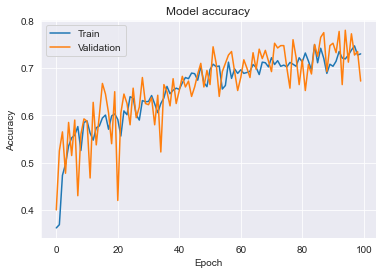

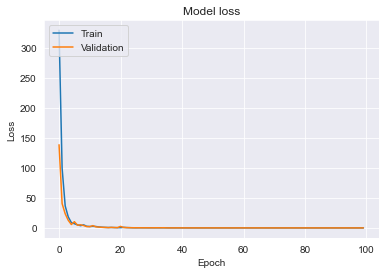

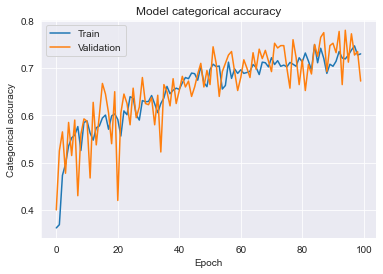

In [16]:
import matplotlib.pyplot as plt

#Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation categorical accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model categorical accuracy')
plt.ylabel('Categorical accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
#run=wandb.init(project="nsiete1")


In [ ]:
wandb.finish()
